In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
#import scipy.signal
#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
#import eofs
#import xrft
#from cdo import Cdo
#cdo = Cdo(tempdir='network/aopp/chaos/pred/leach/.cdo_temp_files')
# uncomment the below if you want to/ clean up the temporary directory
# cdo.cleanTempDir()
#import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
#import regionmask
#import xskillscore as xs
import pandas as pd
#import sys
import glob
#import datetime
#import time
import multiprocessing
#import tqdm
#import cmocean
#import palettable
from shapely.geometry.polygon import LinearRing
#import copy
#import shutil
#import gzip
#import warnings

#sys.path.append('/home/l/luol/Downloads/')
#import ScientificColourMaps6 as SCM6

from IPython.display import display, clear_output

## get FaIR
from fair import *

## get my stats functions
#from mystatsfunctions import OLSE,LMoments
#from moarpalettes import get_palette

## matplotlib rcParams
## IF you want to use thesis style

import requests
from io import StringIO, BytesIO

req = requests.get('https://raw.githubusercontent.com/njleach/Thesis/main/ancil/figure-style.mplstyle')

/home/l/luol/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def import_medr_tracks_TE(fpath):
    
    df = pd.read_csv(fpath,skipinitialspace=True)
    
    expdict = {'1':'ENS','b2nn':'pi','b2nq':'pi','b2ns':'pi','b2no':'incr','b2nr':'incr','b2nt':'incr'}
    
    fname = fpath.split('/')[-1]
    _,expid,inidate,mem = fname.split('_')
    
    df['expid'] = expid
    df['experiment'] = expdict[expid]
    df['inidate'] = pd.to_datetime(inidate)
    df['number'] = int(mem)
    
    return df

In [3]:
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(import_medr_tracks_TE, glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))

P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

## add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==4')

In [4]:

ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date = min, day=np.size, lon = lambda x: x.iloc[0], lat = lambda x: x.iloc[0], msl = min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date = min, day=np.size, lon = lambda x: x.iloc[0], lat = lambda x: x.iloc[0], msl = min)).iloc[0]


In [5]:
## starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)

## starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
## depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]

ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

def eunice_dist(df):
    
    eunice_lons = eunice_track.lon.values
    eunice_lats = eunice_track.lat.values
    
    track_lons = df.lon.values
    track_lats = df.lat.values
    
    minsize = min(eunice_lons.size,track_lons.size)
    
    return np.sqrt((track_lons[:minsize]-eunice_lons[:minsize])**2+(track_lats[:minsize]-eunice_lats[:minsize])**2).sum()


In [6]:
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')
for idx in multi_track_members.index:
    
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(eunice_dist)
    
    num_reject = track_dists.idxmax()
    
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)



In [7]:
import stormeunice as eun

In [12]:

curr_storms = xr.open_mfdataset([x for x in glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/pl/pf/extravars/*.nc') if not '02-16' in x],
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list, sfc=False),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')

AttributeError: 'NoneType' object has no attribute 'sel'

In [9]:

pi_storms = xr.open_mfdataset([x for x in glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/pl/pf/extravars/*.nc') if not '02-16' in x],
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list, sfc=False),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset([x for x in glob.glob('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/pl/pf/extravars/*.nc') if not '02-16'  in x],
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list,sfc=False),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')


/home/l/luol/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/stormeunice/lagrangian.py:297: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date', 'experiment', 'inidate'], dtype='object')
  smoothed_msl = mem_track.rolling(3, center=True).mean().msl
/home/l/luol/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/stormeunice/lagrangian.py:297: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date', 'experiment', 'expid', 'inidate'], dtype='object')
  smoothed_msl = mem_track.rolling(3, center=True).mean().msl
/home/l/luol/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/stormeunice/lagrangian.py:297: Futu

In [ ]:
import metpy
from metpy.units import units
import metpy.calc as mpcalc
from metpy.cbook import get_test_data


In [ ]:
pi_storms.r

,Array,Chunk
Bytes,736.83 MiB,512.58 kiB
Shape,"(2, 1, 32, 46, 10, 81, 81)","(1, 1, 2, 1, 10, 81, 81)"
Count,32222 Tasks,2852 Chunks
Type,float32,numpy.ndarray


In [ ]:

#Comparison plot

# calculate eq potential tempera longitudes between 40°W and 10°E.ture
experiments = ['pi', 'curr', 'incr']
eq_pot_temp = {}
storms = {'pi' : pi_storms, 'curr' : curr_storms, 'incr' : incr_storms}

for exp in experiments:
    pot_temperature = mpcalc.potential_temperature(850 * units.hPa, storms[exp].t * units.kelvin)
    dewpoint = mpcalc.dewpoint_from_relative_humidity(storms[exp].t * units.kelvin, storms[exp].r * units.percent)
    eq_pot_temp[exp] = mpcalc.equivalent_potential_temperature(850 * units.hPa, storms[exp].t * units.kelvin, dewpoint)


NameError: name 'curr_storms' is not defined

So here we have metpy.isentropic_interpolation_as_dataset()
which takes levels of desired isentropic surface (310k ideally but might be 280k in our case) and temperature (idk if it should be on a specific isobaric coordinate or many but we can always try?)data['Temperature'],

The function returns the temperature and pressure(geopotential?) interpolated on the desired isentrope level

To calculate the isentropic slope, we need to convert pressure to geopotential (relatively easy)

Finally, apply numpy.gradient to the entire dataset. Plot the final gradient with isobar contour and vorticity shading with sea/land cover?

Error message for the shell below: 
NotImplementedError: Don't yet support nd fancy indexing

What can I possibily do now...

In [ ]:
isentlevs = [276.]*units.kelvin
prep_storm={}
isent_data = {}

for exp in experiments:
    prep_storm[exp] = storms[exp].sel(timestep=0, experiment=exp,inidate='2022-02-10').mean(dim='number')

    isent_data[exp]  = mpcalc.isentropic_interpolation_as_dataset(
        isentlevs,
        prep_storm[exp].t* units.kelvin
    )
    


    

NotImplementedError: Don't yet support nd fancy indexing

AttributeError: 'Dataset' object has no attribute 'get_array'

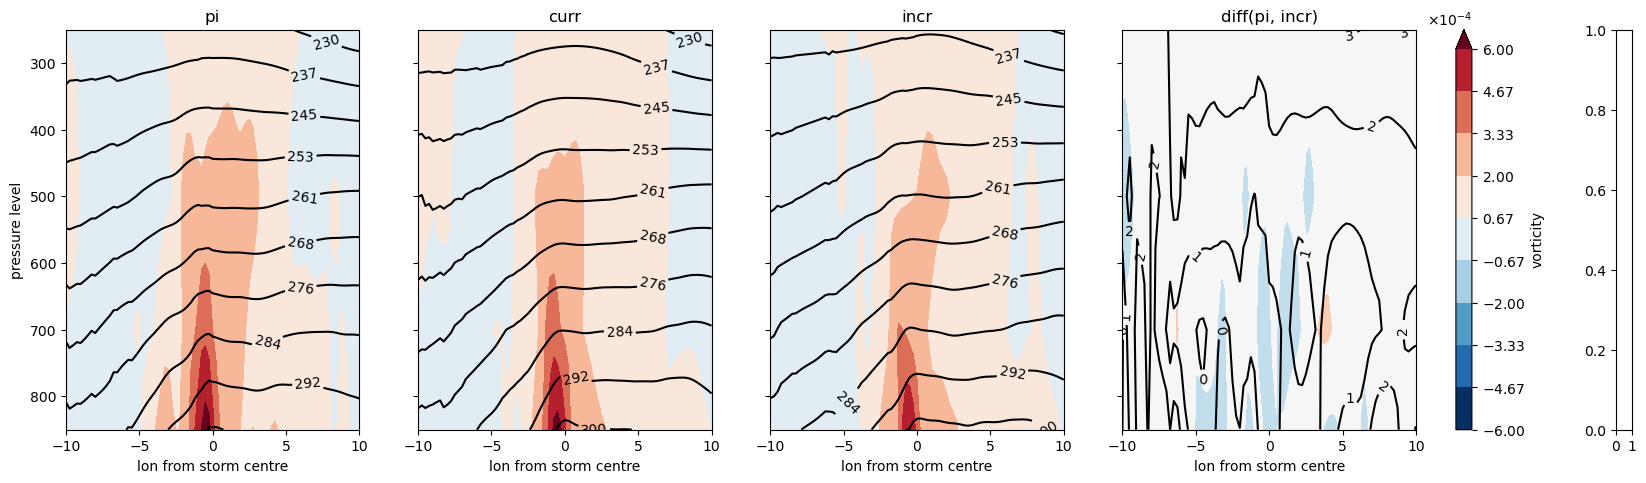

In [ ]:

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
vmin = -0.0006
vmax = 0.0006
levs=10
ts = 0
ini = '2022-02-10'
t_min = 230
t_max = 300
num_levels_t = 10

# pi
pi = pi_storms.sel(storm_lat = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
c = pi.vo.plot.contourf(levels = levs, cmap="RdBu_r", ax=axes[0], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[0].set_ylabel('pressure level')
axes[0].set_xlabel('lon from storm centre')
axes[0].set_title('pi')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[0].contour(pi.storm_lon.values, pi.level.values,
                     eq_pot_temp['pi'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')
axes[0].invert_yaxis()

# curr
curr = curr_storms.sel(storm_lat = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
curr.vo.plot.contourf(ax=axes[1],levels=levs, cmap="RdBu_r", vmin = vmin, vmax = vmax, add_colorbar=False)
axes[1].set_ylabel('')
axes[1].set_xlabel('lon from storm centre')
axes[1].set_title('curr')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[1].contour(pi.storm_lon.values, pi.level.values,
                     eq_pot_temp['curr'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')
axes[1].invert_yaxis()

# incr
incr = incr_storms.sel(storm_lat = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
incr.vo.plot.contourf(ax=axes[2], levels=levs, cmap="RdBu_r", vmin = vmin, vmax = vmax, add_colorbar=False)
axes[2].set_ylabel('')
axes[2].set_xlabel('lon from storm centre')
axes[2].set_title('incr')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[2].contour(pi.storm_lon.values, pi.level.values,
                     eq_pot_temp['incr'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')
axes[2].invert_yaxis()

# diff
diff = incr - pi
c_diff = diff.vo.plot.contourf(ax=axes[3], levels=levs, cmap="RdBu_r", vmin = vmin, vmax = vmax, add_colorbar=False)
axes[3].set_xlabel('lon from storm centre')
axes[3].set_ylabel('')
axes[3].set_title('diff(pi, incr)')

clevs_p = np.linspace(-5, 5, num_levels_t) 
cs = axes[3].contour(pi.storm_lon.values, pi.level.values,
                     eq_pot_temp['incr'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze() - eq_pot_temp['pi'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')
axes[3].invert_yaxis()


# cbars -------------------------
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

cax = plt.axes([0.82, 0.1, 0.008, 0.8])  # left, bottom, width, heightdata['Temperature'],
cax = plt.axes([0.85, 0.1, 0.005, 0.8])
cbar = plt.colorbar(c, cax=cax, label = 'vorticity')

In [ ]:
eq_pot_temp['pi']

<xarray.DataArray 'mul-5a25f78ffc0f0a71add5a03b1765d8a8' (inidate: 2,
                                                          experiment: 1,
                                                          number: 32,
                                                          timestep: 46,
                                                          level: 4,
                                                          storm_lat: 81,
                                                          storm_lon: 81)>
<Quantity(dask.array<mul, shape=(2, 1, 32, 46, 4, 81, 81), dtype=float32, chunksize=(1, 1, 2, 1, 4, 81, 81), chunktype=numpy.ndarray>, 'kelvin')>
Coordinates:
  * storm_lon   (storm_lon) float64 -10.0 -9.75 -9.5 -9.25 ... 9.5 9.75 10.0
  * storm_lat   (storm_lat) float64 -10.0 -9.75 -9.5 -9.25 ... 9.5 9.75 10.0
  * level       (level) int32 250 500 700 850
  * timestep    (timestep) float64 -1.125 -1.0 -0.875 -0.75 ... 4.25 4.375 4.5
  * number      (number) int32 1 2 3 4 6 9 10 13 14 ... 38 39 40 41 43 44 46 49
  * experiment  (experiment) object 'pi'
  * inidate     (inidate) datetime64[ns] 2022-02-10 2022-02-14

Calculating the isentropic slope
We can either try to group entries with the same potential temperature values together and use S=abs(divZ with constant theta) where z is geopotential height
or S=abs(divTheta with const Z/dtheta/dZ)

TypeError: clabel() missing 1 required positional argument: 'CS'

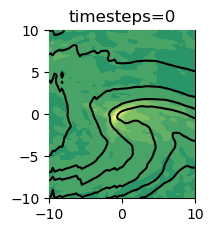

In [ ]:
lat = eq_pot_temp['pi'].storm_lat
lon = eq_pot_temp['pi'].storm_lon
timesteps = [0,0.25,0.5,1.,1.5,2.]

for i in range(6):
    ax=plt.subplot(2,3,i+1)
    ax.set_title('timesteps='+str(timesteps[i]))
    ax.contour(lat,lon, 
                        eq_pot_temp['incr'].sel(experiment='incr',level=850,inidate='2022-02-10',timestep=timesteps[i]).mean('number'),
                        colors='black',zorder=10)
    ax.contourf(lat, lon, storms['incr'].sel(experiment='incr',level=850,inidate='2022-02-10',timestep=timesteps[i]).mean('number').vo, cmap='summer',zorder=5)
    ax.clabel(inline=True, fontsize=10)


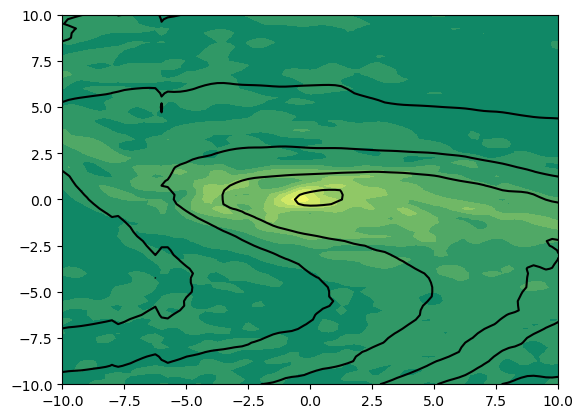

In [ ]:
plt.contour(lat,lon, 
                    eq_pot_temp['incr'].sel(experiment='incr',level=850,inidate='2022-02-10',timestep=0.25).mean('number'),
                    colors='black')
plt.contourf(lat, lon, storms['incr'].sel(experiment='incr',level=850,inidate='2022-02-10',timestep=0.25).mean('number').vo, cmap='summer')

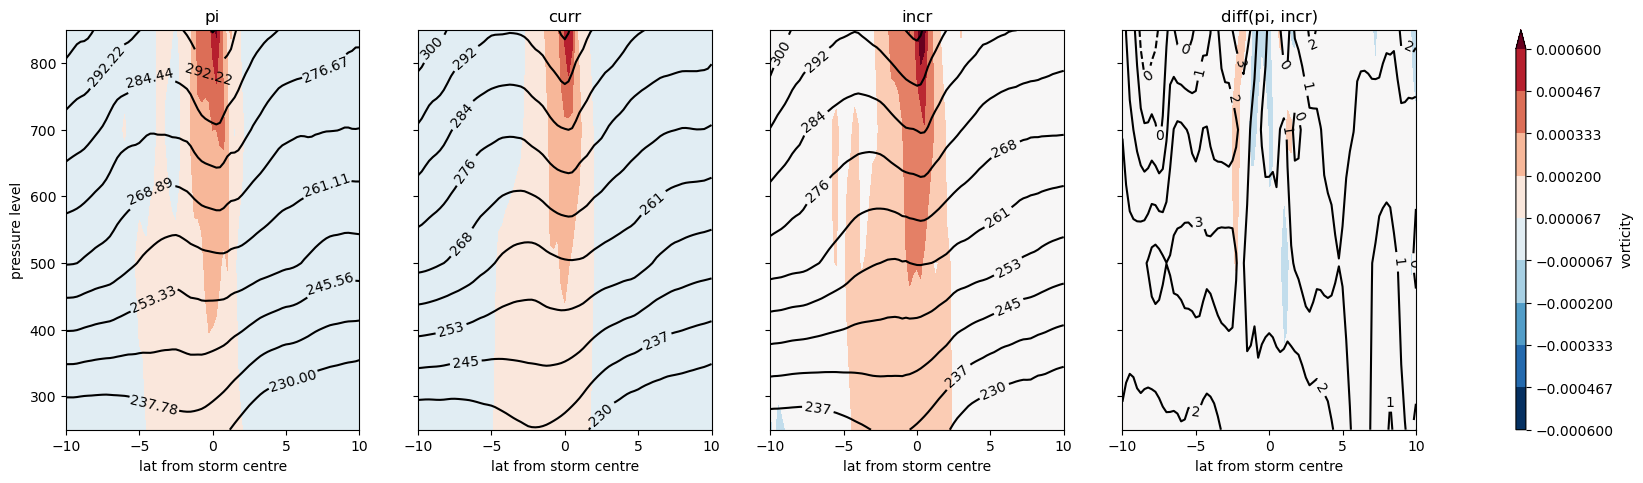

In [ ]:


fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
# pi
pi = pi_storms.sel(storm_lon = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
c = pi.vo.plot.contourf(levels = levs, cmap="RdBu_r", ax=axes[0], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[0].set_ylabel('pressure level')
axes[0].set_xlabel('lat from storm centre')
axes[0].set_title('pi')

clevs_p = np.linspace(t_min, t_max, num_levels_t)

cs = axes[0].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['pi'].sel(inidate=ini, storm_lon=0, timestep=ts).squeeze().mean(dim='number'),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs)

# curr
curr = curr_storms.sel(storm_lon = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
curr.vo.plot.contourf(ax=axes[1],levels=levs, cmap="RdBu_r", vmin = vmin, vmax = vmax, add_colorbar=False)
axes[1].set_ylabel('')
axes[1].set_xlabel('lat from storm centre')
axes[1].set_title('curr')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[1].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['curr'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')

# incr
incr = incr_storms.sel(storm_lon = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
incr.vo.plot.contourf(ax=axes[2], levels=levs, cmap="RdBu_r", vmin = vmin, vmax = vmax, add_colorbar=False)
axes[2].set_ylabel('')
axes[2].set_xlabel('lat from storm centre')
axes[2].set_title('incr')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[2].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['incr'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')

# diff
diff = incr - pi
diff.vo.plot.contourf(ax=axes[3], levels=levs, cmap="RdBu_r", vmin = vmin, vmax = vmax, add_colorbar=False)
axes[3].set_xlabel('lat from storm centre')
axes[3].set_ylabel('')
axes[3].set_title('diff(pi, incr)')

clevs_p = np.linspace(-5, 5, num_levels_t) 
cs = axes[3].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['incr'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze() - eq_pot_temp['pi'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.005, 0.8])
cbar = plt.colorbar(c, cax=cax, label = 'vorticity')

Now that the latitudinal cross section is showing something very interesting. 
--There is a general trend of increasd pv as we can visually infer from the first three subplots, but only a minor increase observed in the difference plot
Does this mean that voticity levels aren't fixed???It shouldn't be the case

Todo 
change pv into PVU--No that is no pv but relative vorticity
fix pv levels--it's fixed already
urgh
reverse y axis values

calculate the isentrope slope??

POTENTIAL VORTICITY NEEDS A PRESSURE DATASET ON A 2D plane:(

Wierd, very weird, why is there a large area filled with white color in incr experiment? It shouldn't be like that theoretically speaking?
also does this mean there is no enough data so it's blank?
vmin = vmin, vmax = vmax,
From pi to incr, the vorticity at max deepening decreased.

In [ ]:
pi_storms.sel(storm_lon = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')


<xarray.Dataset>
Dimensions:       (storm_lat: 81, level: 4)
Coordinates:
    storm_lon     float64 0.0
  * storm_lat     (storm_lat) float64 -10.0 -9.75 -9.5 -9.25 ... 9.5 9.75 10.0
  * level         (level) int32 250 500 700 850
    timestep      float64 0.0
    experiment    <U2 'pi'
    inidate       datetime64[ns] 2022-02-10
Data variables:
    z             (level, storm_lat) float32 dask.array<chunksize=(4, 81), meta=np.ndarray>
    q             (level, storm_lat) float32 dask.array<chunksize=(4, 81), meta=np.ndarray>
    r             (level, storm_lat) float32 dask.array<chunksize=(4, 81), meta=np.ndarray>
    w             (level, storm_lat) float32 dask.array<chunksize=(4, 81), meta=np.ndarray>
    t             (level, storm_lat) float32 dask.array<chunksize=(4, 81), meta=np.ndarray>
    d             (level, storm_lat) float32 dask.array<chunksize=(4, 81), meta=np.ndarray>
    u             (level, storm_lat) float32 dask.array<chunksize=(4, 81), meta=np.ndarray>
    v             (level, storm_lat) float32 dask.array<chunksize=(4, 81), meta=np.ndarray>
    vo            (level, storm_lat) float32 dask.array<chunksize=(4, 81), meta=np.ndarray>
    ws            (level, storm_lat) float32 dask.array<chunksize=(4, 81), meta=np.ndarray>
    centroid_lon  float64 -18.73
    centroid_lat  float64 60.83

In [ ]:
eq_pot_temp['pi'].sel(inidate=ini, storm_lon=0, timestep=ts,experiment='pi').mean(dim='number')

NameError: name 'eq_pot_temp' is not defined

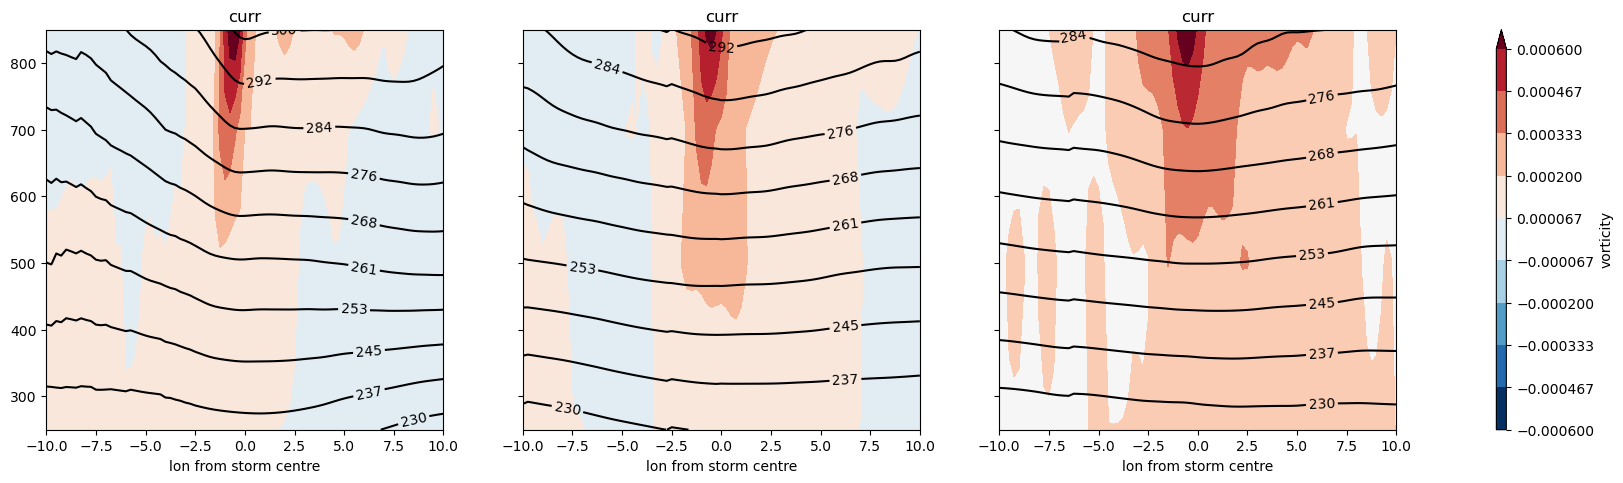

In [ ]:
fig, axes = plt.subplots(1, 5, sharey=True)
# curr
ts_list=[ -0.25 , -0.125,  0.   ,  0.125,  0.25]
for num, value in enumerate(ts_list):
    incr = incr_storms.sel(storm_lat = 0, inidate = ini, timestep = value).squeeze().mean(dim = 'number')
    curr.vo.plot.contourf(ax=axes[num],levels=levs, cmap="RdBu_r", vmin = vmin, vmax = vmax, add_colorbar=False)
    axes[num].set_ylabel('')
    axes[num].set_xlabel('lon from storm centre')
    axes[num].set_title('curr')

    clevs_p = np.linspace(t_min, t_max, num_levels_t) 
    cs = axes[num].contour(pi.storm_lon.values, pi.level.values,
                        eq_pot_temp['incr'].sel(inidate=ini, storm_lat=0, timestep=value).mean(dim='number').squeeze(),clevs_p, colors='black',
                    #  transform=projection,
                        zorder = 16)
    plt.clabel(cs, fmt='%d')


plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.005, 0.8])
cbar = plt.colorbar(c, cax=cax, label = 'vorticity')

/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


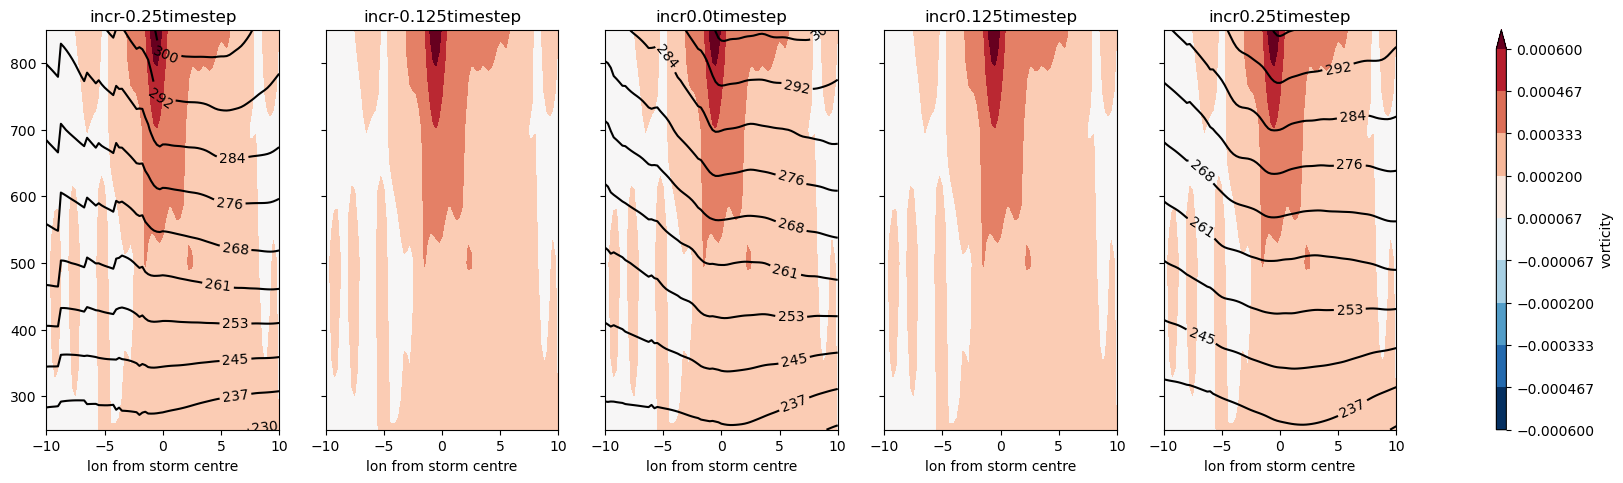

In [ ]:
fig, axes = plt.subplots(1, 5,figsize=(20, 5), sharey=True)
# curr
ts_list=[ -0.25 , -0.125,  0.   ,  0.125,  0.25]
for num, value in enumerate(ts_list):
    incr = incr_storms.sel(storm_lat = 0, inidate = ini, timestep = value).squeeze().mean(dim = 'number')
    curr.vo.plot.contourf(ax=axes[num],levels=levs, cmap="RdBu_r", vmin = vmin, vmax = vmax, add_colorbar=False)
    axes[num].set_ylabel('')
    axes[num].set_xlabel('lon from storm centre')
    axes[num].set_title('incr'+str(value)+'timestep')

    clevs_p = np.linspace(t_min, t_max, num_levels_t) 
    cs = axes[num].contour(pi.storm_lon.values, pi.level.values,
                        eq_pot_temp['incr'].sel(inidate=ini, storm_lat=0, timestep=value).mean(dim='number').squeeze(),clevs_p, colors='black',
                    #  transform=projection,
                        zorder = 16)
    plt.clabel(cs, fmt='%d')


plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.005, 0.8])
cbar = plt.colorbar(c, cax=cax, label = 'vorticity')


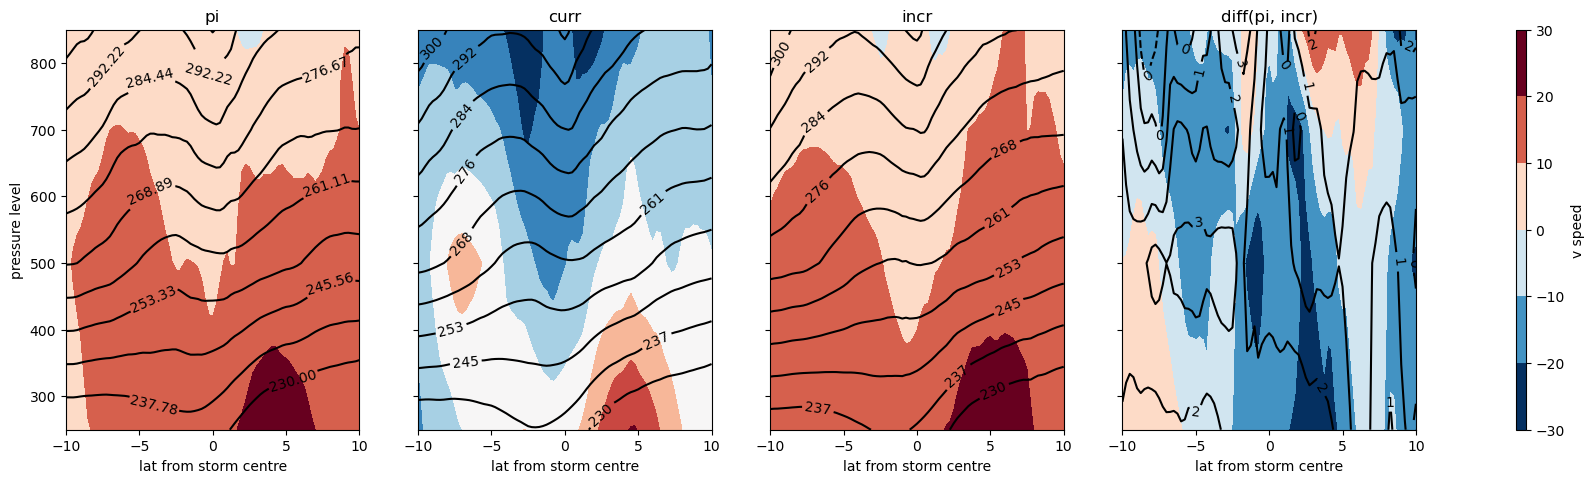

In [ ]:


fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
# pi
pi = pi_storms.sel(storm_lon = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
c = pi.v.plot.contourf(cmap="RdBu_r", ax=axes[0], add_colorbar=False)
axes[0].set_ylabel('pressure level')
axes[0].set_xlabel('lat from storm centre')
axes[0].set_title('pi')

clevs_p = np.linspace(t_min, t_max, num_levels_t)

cs = axes[0].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['pi'].sel(inidate=ini, storm_lon=0, timestep=ts).squeeze().mean(dim='number'),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs)

# curr
curr = curr_storms.sel(storm_lon = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
curr.v.plot.contourf(ax=axes[1], cmap="RdBu_r", add_colorbar=False)
axes[1].set_ylabel('')
axes[1].set_xlabel('lat from storm centre')
axes[1].set_title('curr')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[1].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['curr'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')

# incr
incr = incr_storms.sel(storm_lon = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
incr.v.plot.contourf(ax=axes[2], cmap="RdBu_r", add_colorbar=False)
axes[2].set_ylabel('')
axes[2].set_xlabel('lat from storm centre')
axes[2].set_title('incr')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[2].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['incr'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')

# diff
diff = incr - pi
diff.v.plot.contourf(ax=axes[3], cmap="RdBu_r", add_colorbar=False)
axes[3].set_xlabel('lat from storm centre')
axes[3].set_ylabel('')
axes[3].set_title('diff(pi, incr)')

clevs_p = np.linspace(-5, 5, num_levels_t) 
cs = axes[3].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['incr'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze() - eq_pot_temp['pi'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.005, 0.8])
cbar = plt.colorbar(c, cax=cax, label = 'v speed')

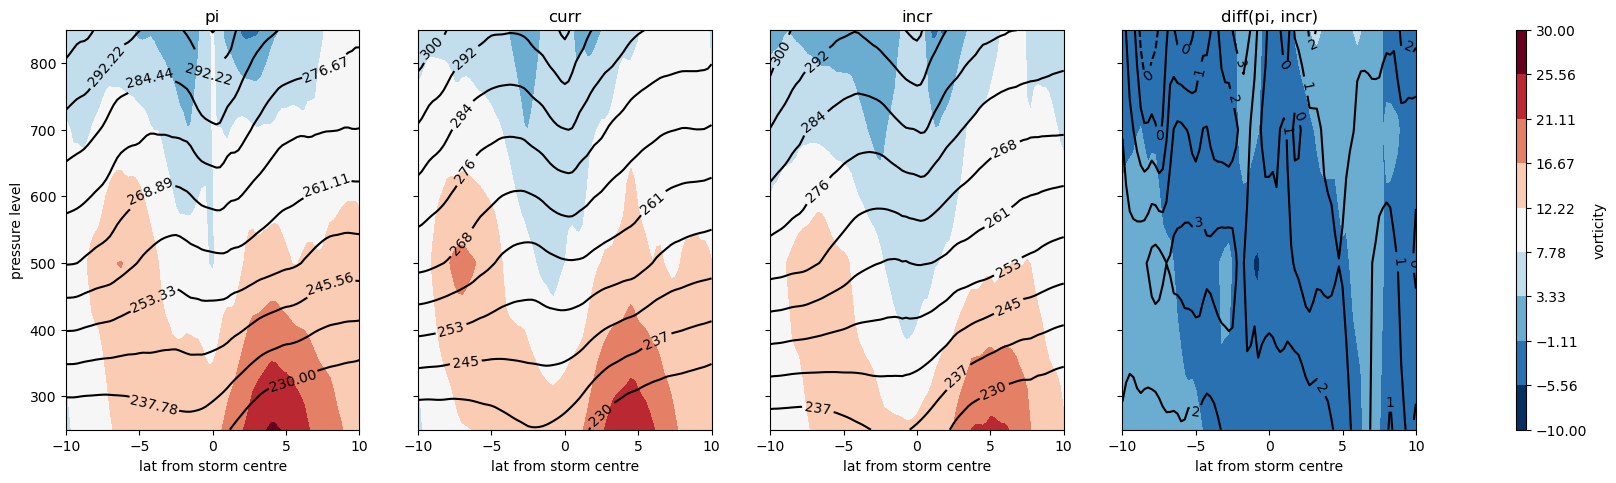

In [ ]:
umin = -10
umax = 30
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
# pi
pi = pi_storms.sel(storm_lon = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
c = pi.v.plot.contourf(levels = levs, cmap="RdBu_r", ax=axes[0], add_colorbar=False, vmin = umin, vmax = umax)
axes[0].set_ylabel('pressure level')
axes[0].set_xlabel('lat from storm centre')
axes[0].set_title('pi')

clevs_p = np.linspace(t_min, t_max, num_levels_t)

cs = axes[0].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['pi'].sel(inidate=ini, storm_lon=0, timestep=ts).squeeze().mean(dim='number'),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs)

# curr
curr = curr_storms.sel(storm_lon = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
curr.v.plot.contourf(ax=axes[1],levels=levs, cmap="RdBu_r", vmin = umin, vmax = umax, add_colorbar=False)
axes[1].set_ylabel('')
axes[1].set_xlabel('lat from storm centre')
axes[1].set_title('curr')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[1].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['curr'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')

# incr
incr = incr_storms.sel(storm_lon = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
incr.v.plot.contourf(ax=axes[2], levels=levs, cmap="RdBu_r", vmin = umin, vmax = umax, add_colorbar=False)
axes[2].set_ylabel('')
axes[2].set_xlabel('lat from storm centre')
axes[2].set_title('incr')

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[2].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['incr'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')

# diff
diff = incr - pi
diff.v.plot.contourf(ax=axes[3], levels=levs, cmap="RdBu_r", vmin = umin, vmax = umax, add_colorbar=False)
axes[3].set_xlabel('lat from storm centre')
axes[3].set_ylabel('')
axes[3].set_title('diff(pi, incr)')

clevs_p = np.linspace(-5, 5, num_levels_t) 
cs = axes[3].contour(pi.storm_lat.values, pi.level.values,
                     eq_pot_temp['incr'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze() - eq_pot_temp['pi'].sel(inidate=ini, storm_lon=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                    #  transform=projection,
                     zorder = 16)
plt.clabel(cs, fmt='%d')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.005, 0.8])
cbar = plt.colorbar(c, cax=cax, label = 'vorticity')